# Manual Ridge Regression

In [1]:
# Import necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Directory where files are stored
DIRECTORY = 'hopkins_export/'  # Adjust this path as needed

### Manual Ridge Regression Class

Ridge Regression is a type of linear regression that adds a regularization term (penalty) to the cost function to prevent overfitting and improve generalization. The regularization term penalizes large coefficients, shrinking them towards zero and thereby reducing model complexity. In this implementation, the model’s coefficients are calculated using a closed-form solution known as the **ridge estimator**, given by the formula:

$${\hat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T y}$$

where ${ \alpha }$ is the regularization parameter, ${ x }$ is the matrix of input features with an added column for the intercept, and ${I}$ is the identity matrix. A higher ${ \alpha }$ value increases regularization, leading to smaller coefficients.


In [3]:
class ManualRidgeRegression:
    def __init__(self, LAMBDA=1.0):
        # Initialize the Ridge Regression model with a regularization parameter lambda
        self.LAMBDA = LAMBDA  # Regularization parameter to control the penalty applied to the coefficients
        self.coef_ = None   # Placeholder for the model's coefficients
        self.intercept_ = None  # Placeholder for the intercept (bias term)

    def fit(self, X, y):
        # Add a bias term (column of ones) to X for calculating the intercept
        X_bias = np.c_[np.ones(X.shape[0]), X]  # Augment X with a column of ones for the intercept

        # Create an identity matrix for the regularization term, matching the dimensions of X_bias
        I = np.eye(X_bias.shape[1])
        I[0, 0] = 0  # Exclude the intercept from regularization by setting the first entry to 0

        # Compute the regularized matrix product: X.T * X + lambda * I
        # This is the closed-form solution for Ridge Regression
        XTX = X_bias.T @ X_bias + self.LAMBDA * I  # (X^T * X) + lambda * I for regularization

        # Compute the product of X.T and y, which is part of the closed-form solution
        XTy = X_bias.T @ y  # Calculate X^T * y

        # Solve for theta (coefficients), which includes both the intercept and the other coefficients
        theta = np.linalg.inv(XTX) @ XTy  # Solve for (X^T * X + lambda * I)^-1 * X^T * y

        # Separate the intercept and the coefficients from the theta vector
        self.intercept_ = theta[0]  # The first element is the intercept
        self.coef_ = theta[1:]      # The remaining elements are the coefficients for the features

    def predict(self, X):
        # Calculate predictions by applying the linear model to the input data X
        # The formula used here is y = X * coef_ + intercept
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        # Calculate the R^2 score, which is a metric for model performance
        y_pred = self.predict(X)  # Generate predictions for the input data X
        ss_total = np.sum((y - np.mean(y)) ** 2)  # Total sum of squares (variation in true values)
        ss_residual = np.sum((y - y_pred) ** 2)  # Residual sum of squares (errors in predictions)
        return 1 - (ss_residual / ss_total)  # R^2 score measures the proportion of explained variance

### Manual K-Fold Split Function

 In K-Fold cross-validation, the dataset is split into k equal parts (folds). For each iteration, one fold is used as the test set while the remaining folds are combined to form the training set. This process is repeated k times, so each fold serves as the test set once. The function shuffles the indices of the data points to ensure randomness and assigns fold sizes evenly. This approach allows for robust model evaluation, as the model is trained and tested on different portions of the data, reducing the risk of overfitting. 

In [4]:
def manual_kfold_split(X, y, n_splits=5, seed=23):
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Create an array of indices representing each data point in the dataset
    indices = np.arange(len(X))

    # Shuffle the indices to randomize the order of data points
    np.random.shuffle(indices)

    # Calculate the size of each fold, distributing any remaining points across the first folds
    fold_sizes = len(X) // n_splits * np.ones(n_splits, dtype=int)  # Initialize each fold size equally
    fold_sizes[:len(X) % n_splits] += 1  # Distribute remainder among the first few folds

    # Initialize a variable to keep track of the current index position in the shuffled indices
    current = 0

    # Initialize an empty list to store the indices of training and test sets for each fold
    splits = []

    # Loop over each fold size to create training and test indices for each split
    for fold_size in fold_sizes:
        # Define the start and stop indices for the test set of the current fold
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]  # Select test indices for the current fold

        # Define the training indices by excluding the test indices from the full set of indices
        train_indices = np.setdiff1d(indices, test_indices)  # Training set excludes current fold

        # Append the training and test indices as a tuple to the splits list
        splits.append((train_indices, test_indices))

        # Update the current index position for the next fold
        current = stop

    # Return the list of training and test indices for each fold
    return splits

### Apply Ridge Regression

In [5]:
# Set parameters for analysis
np.random.seed(23)
LAMBDAs = [0.001, 0.01, 0.1, 1, 10]  # Regularization strengths for Ridge
kf_splits = 5  # Number of K-Folds

# Initialize a dictionary to store the mean R^2 scores for each lambda across all subjects
all_subject_mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}

In [6]:
# Loop through all subject files in the specified directory
subject_files = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]
for subject_file in subject_files:
    # Load each subject dataset
    subject_data = pd.read_csv(os.path.join(DIRECTORY, subject_file))
    
    # Dynamically determine sample sizes for the current subject based on its length
    sample_sizes = np.geomspace(1000, len(subject_data), num=3, dtype=int)

    # Calculate sample fractions for each subject
    sample_fractions = sample_sizes / len(subject_data)  # Adjusted per subject
    
    # Dictionary to hold mean R^2 scores for each lambda for the current subject
    mean_r2_scores = {LAMBDA: [] for LAMBDA in LAMBDAs}
    
    # Loop through each regularization strength (lambda)
    for LAMBDA in LAMBDAs:
        LAMBDA_r2_scores = []  # List to collect R^2 scores for different sample sizes
        for sample_size in sample_sizes:
            # Randomly select a subset of the data for the given sample size
            np.random.seed(23)
            sample_indices = np.random.choice(len(subject_data), sample_size, replace=False)
            X_sample = subject_data.drop(columns=["expected_time", "flip_time", "stim_pos", "user_pos", "lambda_val", "change_rate_x"]).iloc[sample_indices].values
            y_pos_dif = (subject_data["user_pos"].iloc[sample_indices] - subject_data["stim_pos"].iloc[sample_indices]).values

            kf_r2_scores = []  # List to hold R^2 scores for each fold
            
            # Perform manual K-Fold splitting and scoring
            for train_idx, test_idx in manual_kfold_split(X_sample, y_pos_dif, n_splits=kf_splits, seed=23):
                model = ManualRidgeRegression(LAMBDA=LAMBDA)  # Initialize the Ridge model
                model.fit(X_sample[train_idx], y_pos_dif[train_idx])  # Fit the model on training data
                kf_r2_scores.append(model.score(X_sample[test_idx], y_pos_dif[test_idx]))  # Evaluate on test data

            # Calculate the mean R^2 score for the current sample size and lambda
            LAMBDA_r2_scores.append(np.mean(kf_r2_scores))
        
        # Store mean R^2 scores for each lambda across all sample sizes for the current subject
        mean_r2_scores[LAMBDA] = LAMBDA_r2_scores

    # Append each subject's mean R^2 scores
    for LAMBDA in LAMBDAs:
        all_subject_mean_r2_scores[LAMBDA].append(mean_r2_scores[LAMBDA])

In [7]:
# Aggregate results by averaging across all subjects
average_r2_scores = {LAMBDA: np.mean(all_subject_mean_r2_scores[LAMBDA], axis=0) for LAMBDA in LAMBDAs}

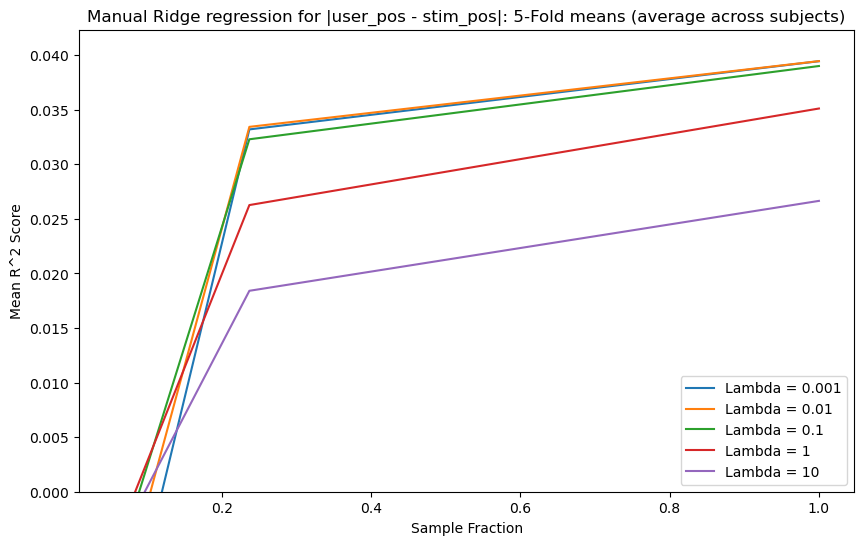

In [11]:
# Plot the results
plt.figure(figsize=(10, 6))
for LAMBDA, avg_r2_scores in average_r2_scores.items():
    plt.plot(sample_fractions, avg_r2_scores, label=f'Lambda = {LAMBDA}')
plt.xlabel('Sample Fraction')
plt.ylabel('Mean R^2 Score')
plt.title('Manual Ridge regression for |user_pos - stim_pos|: 5-Fold means (average across subjects)')
plt.ylim(0,None)
plt.legend()
plt.show()

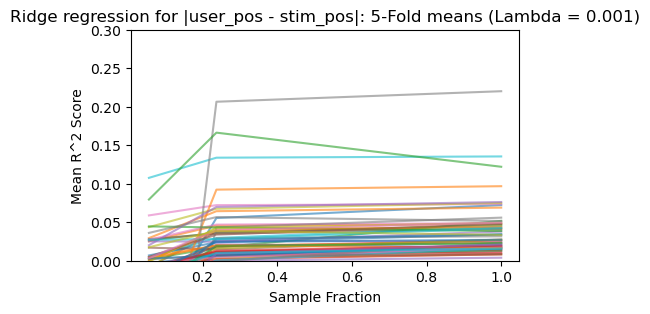

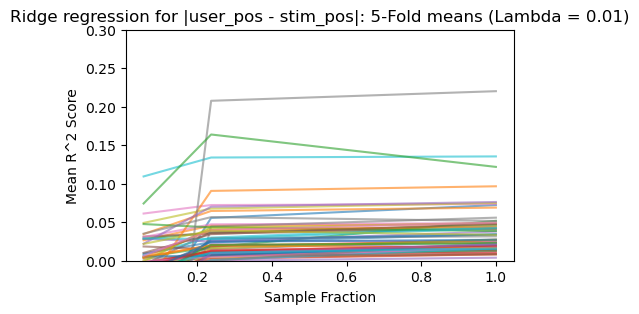

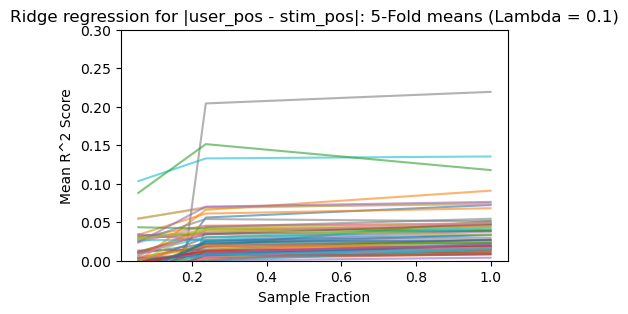

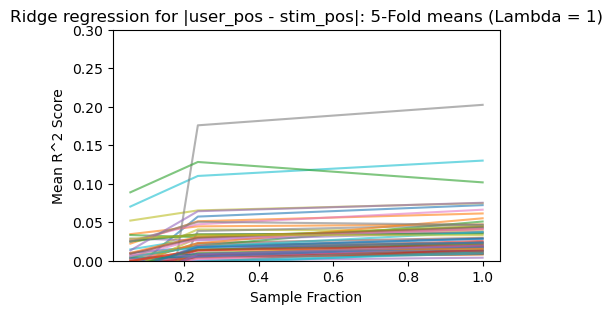

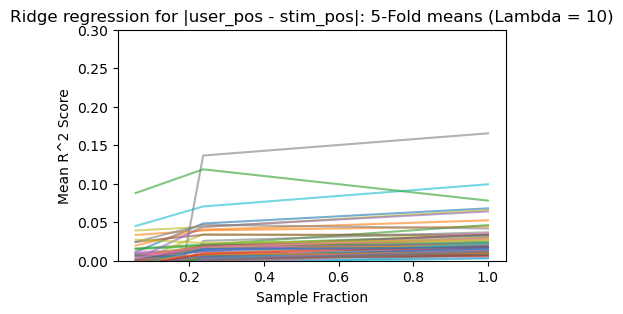

In [10]:
# Plot individual lines for each subject, with one plot per lambda
for LAMBDA in LAMBDAs:
    plt.figure(figsize=(5, 3))
    plt.title(f'Ridge regression for |user_pos - stim_pos|: 5-Fold means (Lambda = {LAMBDA})')
    plt.xlabel('Sample Fraction')
    plt.ylabel('Mean R^2 Score')
    plt.ylim(0,0.3)
    
    # Plot R^2 scores for each subject for the current lambda
    for subject_r2_scores in all_subject_mean_r2_scores[LAMBDA]:
        plt.plot(sample_fractions, subject_r2_scores, linestyle='-', alpha=0.6)
    
    #plt.legend([f'Subject {i+1}' for i in range(len(subject_files))], loc='best', fontsize='small', ncol=2, frameon=False)
    plt.show()


In [ ]:
# Export raw \( R^2 \) scores for each subject
# Create a DataFrame for raw data with columns for lambda, Sample Fraction, Subject, and R^2 Score
raw_data = []
for LAMBDA in LAMBDAs:
    for i, subject_r2_scores in enumerate(all_subject_mean_r2_scores[LAMBDA]):
        for sample_fraction, r2_score in zip(sample_fractions, subject_r2_scores):
            raw_data.append([LAMBDA, sample_fraction, f'Subject {i+1}', r2_score])

# Convert to DataFrame and add labels
raw_data_df = pd.DataFrame(raw_data, columns=['Lambda', 'Sample Fraction', 'Subject', 'R^2 Score'])

# Save raw data to a CSV file
raw_data_df.to_csv('ridge_regression_raw_r2_scores.csv', index=False)

# Export mean \( R^2 \) scores across all subjects for each lambda and sample fraction
mean_data = []
for LAMBDA, avg_r2_scores in average_r2_scores.items():
    for sample_fraction, avg_r2 in zip(sample_fractions, avg_r2_scores):
        mean_data.append([LAMBDA, sample_fraction, avg_r2])

# Convert to DataFrame and add labels
mean_data_df = pd.DataFrame(mean_data, columns=['Lambda', 'Sample Fraction', 'Mean R^2 Score'])

# Save mean data to a CSV file
mean_data_df.to_csv('ridge_regression_mean_r2_scores.csv', index=False)